# Diabetes prediction using synthesized health records

This notebook explores how to train a machine learning model to predict type 2 diabetes using synthesized patient health records.  The use of synthesized data allows us to learn about building a model without any concern about the privacy issues surrounding the use of real patient health records.

## Prerequisites

This project is part of a series of code patterns pertaining to a fictional health care company called Summit Health.  This company stores electronic health records in a database on a z/OS server.  Before running the notebook, the synthesized health records must be created and loaded into this database.  Another project, https://github.com/IBM/summit-health-synthea, provides the steps for doing this.  The records are created using a tool called Synthea (https://github.com/synthetichealth/synthea), transformed and loaded into the database.

## Load and prepare the data

### Set up the information needed for a JDBC connection to your database below
The database must be set up by following the instructions in https://github.com/IBM/summit-health-synthea.

In [5]:
credentials_1 = {
  'host':'xxx.yyy.com',
  'port':'nnnn',
  'username':'user',
  'password':'password',
  'database':'location',
  'schema':'SMHEALTH'
}

### Define a function to load data from a database table into a Spark dataframe

The partitionColumn, lowerBound, upperBound, and numPartitions options are used to load the data more quickly
using multiple JDBC connections.  The data is partitioned by patient id.  It is assumed that there are approximately
5000 patients in the database.  If there are more or less patients, adjust the upperBound value appropriately.

In [6]:
def load_data_from_database(table_name):
    return (
        spark.read.format("jdbc").options(
            driver = "com.ibm.db2.jcc.DB2Driver",
            url = "jdbc:db2://" + credentials_1["host"] + ":" + credentials_1["port"] + "/" + credentials_1["database"],
            user = credentials_1["username"], 
            password = credentials_1["password"], 
            dbtable = credentials_1["schema"] + "." + table_name,
            partitionColumn = "patientid",
            lowerBound = 1,
            upperBound = 5000,
            numPartitions = 10
        ).load()
    )

### Read patient observations from the database

The observations include things like blood pressure and cholesterol readings which are potential features for our model.

In [7]:
observations_df = load_data_from_database("OBSERVATIONS")

observations_df.show(5)

+---------+-----------------+--------+--------------------+------------+--------------+-------+
|PATIENTID|DATEOFOBSERVATION|    CODE|         DESCRIPTION|NUMERICVALUE|CHARACTERVALUE|  UNITS|
+---------+-----------------+--------+--------------------+------------+--------------+-------+
|      222|       2019-01-26|8302-2  |         Body Height|       49.00|              |     cm|
|      222|       2019-01-26|72514-3 |Pain severity - 0...|        1.70|              |{score}|
|      222|       2019-01-26|29463-7 |         Body Weight|        4.50|              |     kg|
|      222|       2019-01-26|6690-2  |Leukocytes [#/vol...|        5.10|              |10*3/uL|
|      222|       2019-01-26|789-8   |Erythrocytes [#/v...|        5.10|              |10*6/uL|
+---------+-----------------+--------+--------------------+------------+--------------+-------+
only showing top 5 rows



### The observations table has a generalized format with a separate row per observation

Let's collect the observations that may be of interest in making a diabetes prediction.
First, select systolic blood pressure readings from the observations.  These have code 8480-6.

In [8]:
from pyspark.sql.functions import col

systolic_observations_df = (
    observations_df.select("patientid", "dateofobservation", "numericvalue")
                   .withColumnRenamed("numericvalue", "systolic")
                   .filter((col("code") == "8480-6"))
  )


systolic_observations_df.show(5)

+---------+-----------------+--------+
|patientid|dateofobservation|systolic|
+---------+-----------------+--------+
|      222|       2019-03-02|  101.30|
|       72|       2009-05-16|  122.70|
|       72|       2010-05-22|  129.10|
|       72|       2011-05-28|  109.00|
|       72|       2012-06-02|  135.40|
+---------+-----------------+--------+
only showing top 5 rows



### Select other observations of potential interest

* Select diastolic blood pressure readings (code 8462-4).
* Select HDL cholesterol readings (code 2085-9).
* Select LDL cholesterol readings (code 18262-6).
* Select BMI (body mass index) readings (code 39156-5).

In [9]:
diastolic_observations_df = (
    observations_df.select("patientid", "dateofobservation", "numericvalue")
                   .withColumnRenamed('numericvalue', 'diastolic')
                   .filter((col("code") == "8462-4"))
    )

hdl_observations_df = (
    observations_df.select("patientid", "dateofobservation", "numericvalue")
                   .withColumnRenamed('numericvalue', 'hdl')
                   .filter((col("code") == "2085-9"))
    )

ldl_observations_df = (
    observations_df.select("patientid", "dateofobservation", "numericvalue")
                   .withColumnRenamed('numericvalue', 'ldl')
                   .filter((col("code") == "18262-6"))
    )

bmi_observations_df = (
    observations_df.select("patientid", "dateofobservation", "numericvalue")
                   .withColumnRenamed('numericvalue', 'bmi')
                   .filter((col("code") == "39156-5"))
    )

### Join the observations for each patient by date into one dataframe

In [10]:
merged_observations_df = (
    systolic_observations_df.join(diastolic_observations_df, ["patientid", "dateofobservation"])
                            .join(hdl_observations_df, ["patientid", "dateofobservation"])
                            .join(ldl_observations_df, ["patientid", "dateofobservation"])
                            .join(bmi_observations_df, ["patientid", "dateofobservation"])
)

merged_observations_df.show(5)

+---------+-----------------+--------+---------+-----+------+-----+
|patientid|dateofobservation|systolic|diastolic|  hdl|   ldl|  bmi|
+---------+-----------------+--------+---------+-----+------+-----+
|        4|       2011-12-17|  105.10|    77.10|71.00| 86.50|57.70|
|      157|       2014-07-16|  138.00|    83.70|21.10|181.40|37.90|
|      230|       2010-04-23|  164.70|   117.90|26.20|147.90|35.20|
|      244|       2015-04-01|  119.00|    84.30|77.60| 96.20|25.50|
|      290|       2018-08-21|  130.60|    70.90|73.90| 77.80|47.10|
+---------+-----------------+--------+---------+-----+------+-----+
only showing top 5 rows



### Another possible feature is the patient's age at the time of observation

Load the patients' birth dates from the database into a dataframe.

In [11]:
patients_df = load_data_from_database("PATIENT").select("patientid", "dateofbirth")

patients_df.show(5)

+---------+-----------+
|patientid|dateofbirth|
+---------+-----------+
|        1| 2017-07-04|
|        2| 1965-04-14|
|        3| 1996-09-14|
|        4| 1958-11-29|
|        5| 1979-01-28|
+---------+-----------+
only showing top 5 rows



Add a column containing the patient's age to the merged observations.

In [12]:
from pyspark.sql.functions import datediff

merged_observations_with_age_df = (
  merged_observations_df.join(patients_df, "patientid")
                        .withColumn("age", datediff(col("dateofobservation"), col("dateofbirth"))/365)
                        .drop("dateofbirth")
  )

merged_observations_with_age_df.show(5)

+---------+-----------------+--------+---------+-----+-----+-----+-----------------+
|patientid|dateofobservation|systolic|diastolic|  hdl|  ldl|  bmi|              age|
+---------+-----------------+--------+---------+-----+-----+-----+-----------------+
|      463|       2016-02-13|  136.90|    81.10|66.60|76.20|35.80|55.57808219178082|
|      463|       2013-01-26|  113.40|    77.50|77.30|91.40|35.80|52.52876712328767|
|      463|       2019-03-02|  123.60|    71.60|73.80|95.50|35.80|58.62739726027397|
|      463|       2010-01-09|  113.50|    70.60|71.20|76.00|35.80|49.47945205479452|
|      471|       2017-07-12|  155.60|    99.00|59.00|83.70|38.30|35.19178082191781|
+---------+-----------------+--------+---------+-----+-----+-----+-----------------+
only showing top 5 rows



### Find the patients that have been diagnosed with type 2 diabetes

The conditions table contains the conditions that patients have and the date they were diagnosed.
Load the patient conditions table and select the patients that have been diagnosed with type 2 diabetes.
Keep the date they were diagnosed ("start" column).

In [13]:
diabetics_df = (
    load_data_from_database("CONDITIONS")
    .select("patientid", "start")
    .filter(col("description") == "Diabetes")
)

diabetics_df.show(5)

+---------+----------+
|patientid|     start|
+---------+----------+
|       66|2003-06-28|
|      281|2012-07-20|
|      230|2008-04-18|
|      157|1994-12-28|
|      251|2011-02-11|
+---------+----------+
only showing top 5 rows



### Create a "diabetic" column which is the "label" for the model to predict

Join the merged observations with the diabetic patients.
This is a left join so that we keep all observations for both diabetic and non-diabetic patients.
Create a new column with a binary value, 1=diabetic, 0=non-diabetic.
This will be the label for the model (the value it is trying to predict).

In [14]:
from pyspark.sql.functions import when

observations_and_condition_df = (
    merged_observations_with_age_df.join(diabetics_df, "patientid", "left_outer")
    .withColumn("diabetic", when(col("start").isNotNull(), 1).otherwise(0))
)

observations_and_condition_df.show(5)

+---------+-----------------+--------+---------+-----+-----+-----+-----------------+-----+--------+
|patientid|dateofobservation|systolic|diastolic|  hdl|  ldl|  bmi|              age|start|diabetic|
+---------+-----------------+--------+---------+-----+-----+-----+-----------------+-----+--------+
|      463|       2013-01-26|  113.40|    77.50|77.30|91.40|35.80|52.52876712328767| null|       0|
|      463|       2010-01-09|  113.50|    70.60|71.20|76.00|35.80|49.47945205479452| null|       0|
|      463|       2016-02-13|  136.90|    81.10|66.60|76.20|35.80|55.57808219178082| null|       0|
|      463|       2019-03-02|  123.60|    71.60|73.80|95.50|35.80|58.62739726027397| null|       0|
|      471|       2017-07-12|  155.60|    99.00|59.00|83.70|38.30|35.19178082191781| null|       0|
+---------+-----------------+--------+---------+-----+-----+-----+-----------------+-----+--------+
only showing top 5 rows



### Filter the observations for diabetics to remove those taken before diagnosis

This is driven by the way that the diabetes simulation works in Synthea.  The impact of the condition (diabetes) is not reflected in the observations until the patient is diagnosed with the condition in a wellness visit.  Prior to that the patient's observations won't be any different from a non-diabetic patient.  Therefore we want only the observations at the time the patients were diabetic.

In [15]:
observations_and_condition_df = (
    observations_and_condition_df.filter((col("diabetic") == 0) | ((col("dateofobservation") >= col("start"))))
)

### Reduce the observations to a single observation per patient (the earliest available observation)

In [16]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

w = Window.partitionBy(observations_and_condition_df["patientid"]).orderBy(merged_observations_df["dateofobservation"].asc())

first_observation_df = observations_and_condition_df.withColumn("rn", row_number().over(w)).where(col("rn") == 1).drop("rn")

## Visualize data

At this point we have collected some observations which might be relevant to making a diabetes prediction.  The next step is to look for relationships between those observations and having diabetes.  There are many tools that help visualize data to look for relationships.  One of the easiest ones to use is called Pixiedust (https://github.com/pixiedust/pixiedust).

Install the pixiedust visualization tool.

In [17]:
# !pip install --upgrade pixiedust

### Use Pixiedust to visualize whether observations correlate with diabetes

The PixieDust interactive widget appears when you run this cell.
* Click the chart button and choose Scatter Plot.
* Click the chart options button.  Drag "ldl" into the Keys box and drag "hdl" into the Values box.
Set the # of Rows to Display to 5000.  Click OK to close the chart options.
* Select bokeh from the Renderer dropdown menu.
* Select diabetic from the Color dropdown menu.

The scatter plot chart appears.

Click Options and try replacing "ldl" and "hdl" with other attributes.

In [18]:
import pixiedust

display(first_observation_df)

## Build and train the model

The visualization of the data showed that the strongest predictors of diabetes are the cholesterol observations.  This is an artifact of the diabetes simulation used to create the synthesized data.  The simulation uses a distinct range of HDL readings for diabetic vs. non-diabetic patients.

The simulation increases the chance of high blood pressure (hypertension) for diabetics but the non-diabetic patients also can have high blood pressure.  Therefore the correlation of high blood pressure to diabetes isn't very strong.

The simulation does not change the weight of any diabetic patients so BMI has no correlation.

Let's continue using HDL and systolic blood pressure as the features for the model.  In reality more features would be needed to build a usable model.

Create a pipeline that assembles the feature columns and runs a logistic regression algorithm.  Then use the observation data to train the model.

In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

vectorAssembler_features = VectorAssembler(inputCols=["hdl", "systolic"], outputCol="features")

lr = LogisticRegression(featuresCol = 'features', labelCol = 'diabetic', maxIter=10)

pipeline = Pipeline(stages=[vectorAssembler_features, lr])

### Split the observation data into two portions

The larger portion (80% of the data) is used to train the model.
The smaller portion (20% of the data) is used to test the model.

In [20]:
split_data = first_observation_df.randomSplit([0.8, 0.2], 24)
train_data = split_data[0]
test_data = split_data[1]

### Train the model

In [21]:
model = pipeline.fit(train_data)

## Evaluate the model

One way to evaluate the model is to plot a precision/recall curve.

Precision measures the percentage of the predicted true outcomes that are actually true.

Recall measures the percentage of the actual true conditions that are predicted as true.

Ideally we want both precision and recall to be 100%.
We want all of the diabetes predictions to actually have diabetes (precision = 1.0).
We want all of the actual diabetics to be predicted to be diabetic (recall = 1.0).

The model computes the probability of a true condition and then compares that to a threshold
(by default 0.5) to make a final true of false determination.  The precision/recall curve plots
precision and recall at various threhold values.

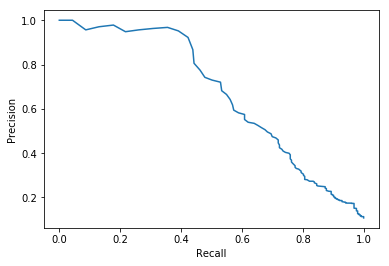

In [22]:
# Plot the model's precision/recall curve.

%matplotlib inline
import matplotlib.pyplot as plt

trainingSummary = model.stages[-1].summary

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Let's use the model to make predictions using the test data.  We'll leave the threshold for deciding between a true or false result at the default value of 0.5.

In [23]:
predictions = model.transform(test_data)

Compute recall and precision for the test predictions to see how well the model does.

In [24]:
pred_and_label = predictions.select("prediction", "diabetic").toPandas()

tp = pred_and_label[(pred_and_label.prediction == 1) & (pred_and_label.diabetic == 1)].count().tolist()[1]
fp = pred_and_label[(pred_and_label.prediction == 1) & (pred_and_label.diabetic == 0)].count().tolist()[1]
fn = pred_and_label[(pred_and_label.prediction == 0) & (pred_and_label.diabetic == 1)].count().tolist()[1]

print("True positives  = %s" % tp)
print("False positives = %s" % fp)
print("False negatives = %s" % fn)

print("Recall = %s" % (tp / (tp + fn)))
print("Precision = %s" % (tp / (tp + fp)))

True positives  = 21
False positives = 9
False negatives = 29
Recall = 0.42
Precision = 0.7


## Publish and deploy the model

In this section you will learn how to store the model in the Watson Machine Learning repository by using the repository client.

First install the client library.

In [25]:
!rm -rf $PIP_BUILD/watson-machine-learning-client
!pip install watson-machine-learning-client --upgrade

    100% |################################| 942kB 3.1MB/s eta 0:00:01
    100% |################################| 163kB 4.2MB/s eta 0:00:01
    100% |################################| 51kB 2.3MB/s eta 0:00:01
    100% |################################| 122kB 3.7MB/s eta 0:00:01
    100% |################################| 51kB 2.1MB/s eta 0:00:01
    100% |################################| 51kB 2.1MB/s eta 0:00:01
    100% |################################| 10.0MB 1.1MB/s eta 0:00:01
    100% |################################| 61kB 2.8MB/s eta 0:00:01
    100% |################################| 1.1MB 3.8MB/s eta 0:00:01
    100% |################################| 215kB 3.9MB/s eta 0:00:01
    100% |################################| 512kB 3.9MB/s eta 0:00:01
    100% |################################| 235kB 3.9MB/s eta 0:00:01
    100% |################################| 17.2MB 831kB/s eta 0:00:01
    100% |################################| 143kB 4.5MB/s eta 0:00:01
    100% |############

### Enter your Watson Machine Learning service instance credentials here
They can be found in the Service Credentials tab of the Watson Machine Learning service instance that you created on IBM Cloud.

In [26]:
wml_credentials={
  "url": "https://xxx.ibm.com",
  "username": "xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx",
  "password": "xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx",
  "instance_id": "xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx"
}

### Publish the model to the repository using the client

In [27]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

client = WatsonMachineLearningAPIClient(wml_credentials)

model_props = {
    client.repository.ModelMetaNames.NAME: "diabetes-prediction-1",
}

stored_model_details = client.repository.store_model(model, meta_props=model_props, training_data=train_data, pipeline=pipeline)

model_uid            = client.repository.get_model_uid( stored_model_details )
print( "model_uid: ", model_uid )

model_uid:  e3be3fe1-3bd9-4670-b97a-03af983cdb40


### Deploy the model as a web service

In [28]:
deployment_details = client.deployments.create(model_uid, 'diabetes-prediction-1 deployment')

scoring_endpoint = client.deployments.get_scoring_url(deployment_details)
print(scoring_endpoint)



#######################################################################################

Synchronous deployment creation for uid: 'e3be3fe1-3bd9-4670-b97a-03af983cdb40' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f22520a9-8518-459f-8613-5b50e16b08f2'
------------------------------------------------------------------------------------------------


https://us-south.ml.cloud.ibm.com/v3/wml_instances/4625e647-f20e-4d7c-b23c-f287445a8f23/deployments/f22520a9-8518-459f-8613-5b50e16b08f2/online


### Call the web service to make a prediction from some sample data

In [29]:
scoring_payload = {
    "fields": ["hdl", "systolic"],
    "values": [[45.0, 156.6]]
}

score = client.deployments.score(scoring_endpoint, scoring_payload)

print(str(score))

{'values': [[45.0, 156.6, [45.0, 156.6], [-0.3141354817235511, 0.3141354817235511], [0.4221056369793351, 0.5778943630206649], 1.0]], 'fields': ['hdl', 'systolic', 'features', 'rawPrediction', 'probability', 'prediction']}
